# Tracking an object using the Kalman filter





Consider an object moving in $R^2$.
We assume that we observe a noisy version of its location at each time step.
We want to track the object and possibly forecast its future motion.
We now show how to do this using a simple linear Gaussian SSM, combined with 
the Kalman filter algorithm.

Let the hidden state represent
the position and velocity of the object,
$z_t =\begin{pmatrix} u_t & \dot{u}_t & v_t & \dot{v}_t \end{pmatrix}$.
(We use $u$ and $v$ for the two coordinates,
to avoid confusion with the state and observation variables.)
The process evolves in continuous time, but if we discretize it with step size $\Delta$,
we can write the dynamics as the following linear system:

\begin{align}
\underbrace{\begin{pmatrix} u_t\\ \dot{u}_t \\ v_t \\ \dot{v}_t \end{pmatrix}}_{z_t}
  = 
\underbrace{
\begin{pmatrix}
1 & 0 & \Delta & 0 \\
0 & 1 & 0 & \Delta\\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
}_{F}
\underbrace{\begin{pmatrix} u_{t-1} \\ \dot{u}_{t-1} \\ v_{t-1} \\ \dot{v}_{t-1} \end{pmatrix}}_{z_{t-1}}
+ q_t
\end{align}

where $q_t \in R^4$ is the process noise, which we assume is Gaussian,
so  $q_t \sim N(0,Q)$.




Now suppose that at each discrete time point we
observe the location (but not the velocity).
We assume the observation is corrupted by  Gaussian noise.
Thus the observation model becomes

\begin{align}
\underbrace{\begin{pmatrix}  y_{1,t} \\  y_{2,t} \end{pmatrix}}_{y_t}
  &=
    \underbrace{
    \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
    \end{pmatrix}
    }_{H}
    
\underbrace{\begin{pmatrix} u_t\\ \dot{u}_t \\ v_t \\ \dot{v}_t \end{pmatrix}}_{z_t}    
 + r_t
\end{align}

where $r_t \sim N(0,R)$ is the observation noise.
We see that the observation matrix $H$ simply ``extracts'' the
relevant parts  of the state vector.



# Setup

In [1]:


try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax

In [2]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [3]:
from jax import numpy as jnp
from jax import random as jr
from matplotlib import pyplot as plt

from dynamax.plotting import plot_lgssm_posterior
from dynamax.linear_gaussian_ssm.models.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.linear_gaussian_ssm.inference import LGSSMParams, lgssm_smoother, lgssm_filter
from dynamax.linear_gaussian_ssm.demos.kf_tracking import kf_tracking, plot_kf_tracking

# Create the model

In [4]:


state_dim = 4
emission_dim = 2
delta = 1.0

# Create object
lgssm = LinearGaussianSSM(state_dim, emission_dim)

# Random model parameters
params, _ = lgssm.random_initialization(jr.PRNGKey(0))

# Manually chosen parameters
mu0 = jnp.array([8.0, 10.0, 1.0, 0.0])
Sigma0 = jnp.eye(state_dim) * 0.1
F  = jnp.array([[1, 0, delta, 0],
                [0, 1, 0, delta],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])
Q = jnp.eye(state_dim) * 0.001
H = jnp.array([[1.0, 0, 0, 0],
                [0, 1.0, 0, 0]])
R = jnp.eye(emission_dim) * 1.0

params['initial']['mean'] = mu0
params['initial']['cov'] = Sigma0
params['dynamics']['weights'] = F
params['dynamics']['cov'] = Q
params['emissions']['weights'] = H
params['emissions']['cov'] = R

# Sample some data from the model

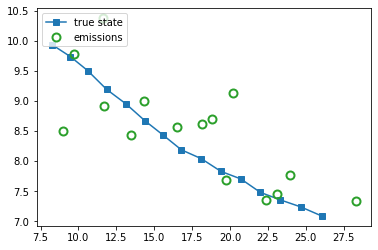

In [6]:
num_timesteps = 15
key = jr.PRNGKey(310)
x, y = lgssm.sample(params, key, num_timesteps)

# Plot Data
observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
fig1, ax1 = plt.subplots()
ax1.plot(*x[:, :2].T, marker="s", color="C0", label="true state")
ax1.plot(*y.T, ls="", **observation_marker_kwargs, color="tab:green", label="emissions")
ax1.legend(loc="upper left")



# Perform online filtering



In [13]:
lgssm_posterior = lgssm.filter(params, y)

from dataclasses import dataclass
from dataclasses import fields
attributes = [field.name for field in fields(lgssm_posterior)]
print(attributes)

print(lgssm_posterior.filtered_means.shape)
print(lgssm_posterior.filtered_covariances.shape)
print(lgssm_posterior.marginal_loglik)
# The smoothed outputs are None


['marginal_loglik', 'filtered_means', 'filtered_covariances', 'smoothed_means', 'smoothed_covariances', 'smoothed_cross_covariances']
(15, 4)
(15, 4, 4)
-43.13845


<AxesSubplot:>

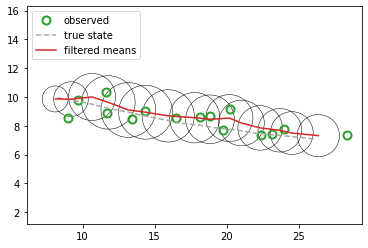

In [14]:
fig2, ax2 = plt.subplots()
ax2.plot(*y.T, ls="", **observation_marker_kwargs, color="tab:green", label="observed")
ax2.plot(*x[:, :2].T, ls="--", color="darkgrey", label="true state")
plot_lgssm_posterior(
    lgssm_posterior.filtered_means,
    lgssm_posterior.filtered_covariances,
    ax2,
    color="tab:red",
    label="filtered means",
    ellipse_kwargs={"edgecolor": "k", "linewidth": 0.5},
    legend_kwargs={"loc":"upper left"}
)

# Perform offline smoothing

In [15]:
lgssm_posterior = lgssm.smoother(params, y)

<AxesSubplot:>

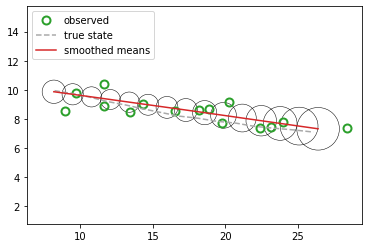

In [16]:
fig3, ax3 = plt.subplots()
ax3.plot(*y.T, ls="", **observation_marker_kwargs, color="tab:green", label="observed")
ax3.plot(*x[:, :2].T, ls="--", color="darkgrey", label="true state")
plot_lgssm_posterior(
    lgssm_posterior.smoothed_means,
    lgssm_posterior.smoothed_covariances,
    ax3,
    color="tab:red",
    label="smoothed means",
    ellipse_kwargs={"edgecolor": "k", "linewidth": 0.5},
    legend_kwargs={"loc":"upper left"}
)

# Low-level interface to the underlying inference algorithms

We can also call the inference code directly, without having to make an LG-SSM object.
We just bundle the parameters together into an `LGSSMParams` dataclass and call
the underlying inference functions.

In [18]:
 # Specify the model parameters


params = LGSSMParams(
    initial_mean=mu0, 
    initial_covariance=Sigma0,
    dynamics_matrix=F,
    dynamics_covariance=Q,
    emission_matrix=H,
    emission_covariance=R
)

filtered_posterior = lgssm_filter(params, y) # Kalman filter
smoothed_posterior = lgssm_smoother(params, y) # Kalman filter + smoother
assert jnp.allclose(lgssm_posterior.filtered_means, filtered_posterior.filtered_means)
assert jnp.allclose(lgssm_posterior.filtered_means, smoothed_posterior.filtered_means)
assert jnp.allclose(lgssm_posterior.smoothed_means, smoothed_posterior.smoothed_means)